In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
#import tensorflow as tf
from tensorflow.keras import layers
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import os
from sklearn.model_selection import train_test_split
from skimage import data,segmentation,measure,morphology,color
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow_core.python.keras.layers.convolutional import Conv2D
#from tensorflow_core.python.keras.layers import Dense,Flatten
#from tensorflow_core.python.keras.models import Model


import math
print(tf.__version__)

2.9.2


In [3]:
import numpy as np
#from tensorflow_core.python.ops.init_ops_v2 import he_normal
import os 
from PIL import Image 
import numpy as np 
import cv2
#import tensorflow_probability as tfp

In [4]:
import tensorflow_probability as tpf

In [5]:
#from tensorflow_probability.substrates import jax as tfp
#tensorflow-probability==0.11.1

In [6]:
"""
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
sess = tf.compat.v1.Session(config=config)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

version = tf.__version__
gpu_ok = tf.test.is_gpu_available()

print("tf version:", version)
print("use GPU:", gpu_ok)"""


'\nconfig = tf.compat.v1.ConfigProto()\nconfig.gpu_options.allow_growth = True\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.95\nsess = tf.compat.v1.Session(config=config)\nos.environ["CUDA_VISIBLE_DEVICES"] = "0"\n\nversion = tf.__version__\ngpu_ok = tf.test.is_gpu_available()\n\nprint("tf version:", version)\nprint("use GPU:", gpu_ok)'

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)
version = tf.__version__
gpu_ok = tf.test.is_gpu_available()
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("tf version:",version,"\nuse GPU",gpu_ok)

In [ ]:
import sys, platform

platform.architecture()

In [10]:
##import data

In [11]:
img_size = 224
source_path = 'EuroSAT_RGB'
target_name = 'Impervious_jpg'#negative'#'positive'
category_dir = os.path.join(source_path, target_name)
target_data = []
for img in os.listdir(category_dir):
    try:
        img = cv2.imread(os.path.join(category_dir, img))
        img = cv2.resize(img, (img_size, img_size))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    except:
        continue
    target_data.append(img)

In [12]:
target_data = np.array(target_data)/255.
target_data = target_data.astype('float32')
target_data.shape

(1659, 224, 224, 3)

In [13]:
reference_data = []
reference_label = []
label = 0
source_path = os.walk(r"EuroSAT_RGB")

for path, dir_list, file_list in source_path:  
    for dir_name in dir_list:
        if label <= 100 and dir_name != target_name and not dir_name.startswith('.ipynb_checkpoints'):
            print('label:', label, dir_name)
            category_dir = os.path.join(path, dir_name)

            for img in os.listdir(category_dir):
                try:
                    img = cv2.imread(os.path.join(category_dir, img))
                    img = cv2.resize(img, (img_size, img_size))
                    reference_data.append(img)
                    reference_label.append(label)
                except:
                    continue
            label += 1

label: 0 Forest
label: 1 HerbaceousVegetation
label: 2 PermanentCrop
label: 3 AnnualCrop
label: 4 River
label: 5 SeaLake
label: 6 Pasture


In [14]:
reference_data = np.array(reference_data)/255.
reference_data = reference_data.astype('float32')


In [15]:
num_class = len(np.unique(reference_label))

In [16]:
print(num_class)

7


In [17]:
reference_label = np.array(reference_label)
reference_label = reference_label.astype('int')
reference_label = np.eye(num_class)[reference_label]
reference_label = reference_label.astype('float32')
reference_data.shape

(19000, 224, 224, 3)

In [18]:
##Splitting data

In [19]:
Rdata_train,Rdata_test, Rlabel_train, Rlabel_test = train_test_split(reference_data,reference_label,test_size = 0.3,
                                                   random_state = 40)
Tdata_train,Tdata_test = train_test_split(target_data,test_size = 0.3,
                                                   random_state = 40)

In [20]:
print(Rdata_test.shape)
print(Tdata_test.shape)

(5700, 224, 224, 3)
(498, 224, 224, 3)


In [21]:
print(Rdata_train.shape)
print(Tdata_train.shape)

(13300, 224, 224, 3)
(1161, 224, 224, 3)


In [22]:
print(num_class)

7


In [23]:
batch_size = 10

reference_dataset = tf.data.Dataset.from_tensor_slices((Rdata_train, Rlabel_train))
reference_dataset = reference_dataset.shuffle(buffer_size = len(Rdata_train))
reference_dataset = reference_dataset.batch(batch_size)

target_dataset = tf.data.Dataset.from_tensor_slices(Tdata_train)
target_dataset = target_dataset.shuffle(buffer_size=len(Tdata_train))
target_dataset = target_dataset.batch(batch_size)

In [24]:
print(reference_dataset)
print(target_dataset)
print(num_class)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>
<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>
7


In [25]:
##pre_train model

In [26]:
input_shape = (224,224,3)
pre_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = input_shape) #include_top: 全盤接受VGG16
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
##TRANSFER LEARNING

In [28]:
def block(x, layers):
    
    x = tf.keras.layers.Dense(layers, activation = 'linear')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    return x

In [29]:
def make_model(model, trainable = False):
    if trainable:
        model.trainable = True
    else:
        model.trainable = False
    x = tf.keras.layers.Flatten()(model.output)
    x = block(x,1000)
    x = block(x,1000)

    output_t = tf.keras.layers.Dense(1000)(x)
    
    target_model = tf.keras.Model(inputs = model.input, outputs = output_t)
    
    output_r = tf.keras.layers.Dense(num_class, activation = tf.nn.softmax, use_bias = True)(target_model.output)
    
    related_model = tf.keras.Model(inputs = model.input, outputs = output_r)    
    
    return related_model, target_model

In [30]:
related_model, target_model =  make_model(model = pre_model, trainable = False)

In [31]:
target_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
related_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [33]:
##training parameters

In [34]:
base_lr = 1e-4
max_lr = 1e-3

com_loss_weight = 15

#des_loss_weight = 0.5

n_samples = len(reference_data)
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0   

m_optimizer = tf.keras.optimizers.Adam(lr = base_lr)

/home/jovyan/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
##model loss

In [36]:
Crossentropy = tf.keras.losses.CategoricalCrossentropy()
def descriptiveness_loss(y_true, y_pred):
    
    loss = Crossentropy(y_true, y_pred)
    
    return  loss

def compactness_loss(num_class, output):
    
    n = output.shape[0]
    print(n)
    loss = 1/(num_class * n) * tf.reduce_sum(n**2/(n-1)**2 * tf.math.reduce_std(output,axis = 1) **2, axis = 0)   
    return loss

In [37]:
print(num_class)

7


In [38]:
@tf.function
def update_model(batch_traget_x, batch_related_x,  batch_related_y):

    with tf.GradientTape() as m_tape:
        
        output_related = related_model(batch_related_x, training = True)
        output_target = target_model(batch_traget_x, training = True)
        
        des_loss = descriptiveness_loss(batch_related_y, output_related)
        com_loss = compactness_loss(num_class, output_target)  
        total_loss =  des_loss + com_loss*com_loss_weight

    m_grads = m_tape.gradient(total_loss, related_model.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, related_model.trainable_variables))
    
    return des_loss, com_loss, total_loss

In [39]:
#output_target = target_model(batch_traget_x, training = True)

In [40]:
#batch_traget_x.shape

In [41]:
#output_target.shape

In [42]:

#compactness_loss(num_class, output_target)\ 

In [43]:
##Train a classification model

In [44]:
#for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):
#    print(batch_traget_x.shape[0])

In [45]:
# Set learning rate to 0.001
lr = 0.00001


epochs = 100

pre_loss = 0
des_loss_list = []
com_loss_list = []
total_loss_list = []

for epoch in range(epochs):
    start = time.time()


    des_loss_avg = tf.metrics.Mean()
    com_loss_avg = tf.metrics.Mean()
    total_loss_avg = tf.metrics.Mean()

    for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):
        if batch_traget_x.shape[0] != 1:


            m_optimizer.lr = lr
            des_loss, com_loss, total_loss = update_model(batch_traget_x, batch_related_x,  batch_related_y)
            des_loss_avg(des_loss)
            com_loss_avg(com_loss)
            total_loss_avg(total_loss)
            epoch_time = time.time() - start

     
    des_loss_list.append(des_loss)
    com_loss_list.append(com_loss)
    total_loss_list.append(total_loss)
    
    if abs(pre_loss - com_loss_avg.result()) < 1e-8:
        break
    pre_loss  = com_loss_avg.result()

    if epoch % 1 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  DES_LOSS: {:.4f} COM_LOSS: {:.8f} TOTAL_LOSS: {:.4f}'.format(epoch, 
                                    epoch_time, des_loss_avg.result(),com_loss_avg.result(),total_loss_avg.result()))

10
10


2023-06-30 11:27:07.329785: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 11:27:07.329828: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 11:27:07.663403: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 11:27:07.663439: W tensorflow/core/common_runtime/bfc_allocato

   0: TIME: 25.50  DES_LOSS: 1.7703 COM_LOSS: 0.01067184 TOTAL_LOSS: 1.9304
   1: TIME: 6.51  DES_LOSS: 1.4487 COM_LOSS: 0.00402235 TOTAL_LOSS: 1.5090
   2: TIME: 6.65  DES_LOSS: 1.2301 COM_LOSS: 0.00334465 TOTAL_LOSS: 1.2802
   3: TIME: 6.69  DES_LOSS: 1.0872 COM_LOSS: 0.00304085 TOTAL_LOSS: 1.1328
   4: TIME: 6.68  DES_LOSS: 0.9841 COM_LOSS: 0.00238938 TOTAL_LOSS: 1.0199
   5: TIME: 6.79  DES_LOSS: 0.9571 COM_LOSS: 0.00215332 TOTAL_LOSS: 0.9894
   6: TIME: 6.81  DES_LOSS: 0.8609 COM_LOSS: 0.00184900 TOTAL_LOSS: 0.8887
   7: TIME: 6.82  DES_LOSS: 0.8046 COM_LOSS: 0.00185836 TOTAL_LOSS: 0.8325
   8: TIME: 6.94  DES_LOSS: 0.8062 COM_LOSS: 0.00155513 TOTAL_LOSS: 0.8295
   9: TIME: 6.89  DES_LOSS: 0.7627 COM_LOSS: 0.00147376 TOTAL_LOSS: 0.7848
  10: TIME: 6.93  DES_LOSS: 0.7298 COM_LOSS: 0.00136976 TOTAL_LOSS: 0.7504
  11: TIME: 6.91  DES_LOSS: 0.7276 COM_LOSS: 0.00121451 TOTAL_LOSS: 0.7458
  12: TIME: 6.87  DES_LOSS: 0.6763 COM_LOSS: 0.00110719 TOTAL_LOSS: 0.6930
  13: TIME: 6.96  DES_LO

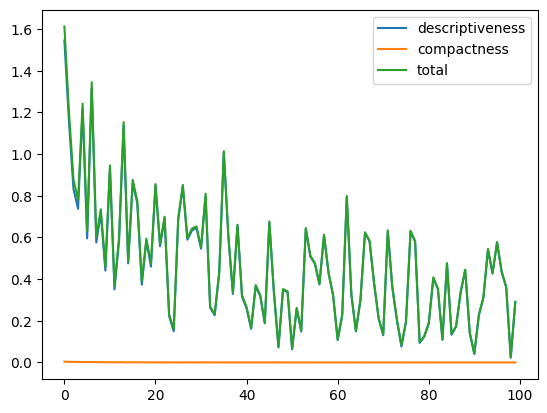

In [46]:
plt.plot(des_loss_list, label = 'descriptiveness')
plt.plot(com_loss_list, label = 'compactness')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()

In [53]:
#original
epochs = 10

pre_loss = 0
des_loss_list = []
com_loss_list = []
total_loss_list = []

for epoch in range(epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [5, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    des_loss_avg = tf.metrics.Mean()
    com_loss_avg = tf.metrics.Mean()
    total_loss_avg = tf.metrics.Mean()

    for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):
        if batch_traget_x.shape[0] != 1:

            # Calculate cyclic learning rate
            global_step = global_step + 1
            cycle = np.floor(1 + global_step / (2 * step_size))
            x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
            clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

            m_optimizer.lr = clr
            des_loss, com_loss, total_loss = update_model(batch_traget_x, batch_related_x,  batch_related_y)
            des_loss_avg(des_loss)
            com_loss_avg(com_loss)
            total_loss_avg(total_loss)
            epoch_time = time.time() - start

     
    des_loss_list.append(des_loss)
    com_loss_list.append(com_loss)
    total_loss_list.append(total_loss)
    
    if abs(pre_loss - com_loss_avg.result()) < 1e-8:
        break
    pre_loss  = com_loss_avg.result()

    if epoch % 1 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  DES_LOSS: {:.4f} COM_LOSS: {:.8f} TOTAL_LOSS: {:.4f}'.format(epoch, 
                                    epoch_time, des_loss_avg.result(),com_loss_avg.result(),total_loss_avg.result()))

   0: TIME: 6.98  DES_LOSS: 0.7253 COM_LOSS: 0.00960043 TOTAL_LOSS: 0.7258
   1: TIME: 7.02  DES_LOSS: 0.8799 COM_LOSS: 0.00779425 TOTAL_LOSS: 0.8803
   2: TIME: 6.96  DES_LOSS: 0.8195 COM_LOSS: 0.00623548 TOTAL_LOSS: 0.8198
   3: TIME: 7.00  DES_LOSS: 0.8546 COM_LOSS: 0.00746325 TOTAL_LOSS: 0.8550
   4: TIME: 7.05  DES_LOSS: 0.8725 COM_LOSS: 0.01074766 TOTAL_LOSS: 0.8730
learning rate changed!
   5: TIME: 7.01  DES_LOSS: 0.9318 COM_LOSS: 0.00900758 TOTAL_LOSS: 0.9323
   6: TIME: 7.00  DES_LOSS: 0.9641 COM_LOSS: 0.00828861 TOTAL_LOSS: 0.9645
   7: TIME: 7.00  DES_LOSS: 0.8148 COM_LOSS: 0.01130627 TOTAL_LOSS: 0.8153
   8: TIME: 7.01  DES_LOSS: 0.7629 COM_LOSS: 0.00901042 TOTAL_LOSS: 0.7634
   9: TIME: 7.04  DES_LOSS: 0.7114 COM_LOSS: 0.01108079 TOTAL_LOSS: 0.7119


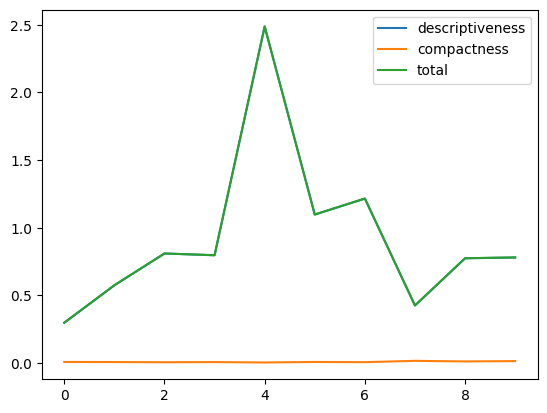

In [54]:
plt.plot(des_loss_list, label = 'descriptiveness')
plt.plot(com_loss_list, label = 'compactness')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()

In [47]:
##FINE-TUNING

In [47]:
related_model.trainable = True 
target_model.trainable = True 
related_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [48]:
target_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
@tf.function
def update_model(batch_traget_x, batch_related_x,  batch_related_y):

    with tf.GradientTape() as m_tape:
        
        output_related = related_model(batch_related_x, training = True)
        output_target = target_model(batch_traget_x, training = True)
        
        des_loss = descriptiveness_loss(batch_related_y, output_related)
        com_loss = compactness_loss(num_class, output_target)  
        total_loss =  des_loss + com_loss_weight * com_loss

    m_grads = m_tape.gradient(total_loss, related_model.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, related_model.trainable_variables))
    
    return des_loss, com_loss, total_loss

In [50]:
base_lr = 1e-6
max_lr = 1e-5
layer_num = 0
inputs = target_model

In [51]:
#print(zip(target_dataset, reference_dataset))

In [52]:
epochs = 60

pre_loss = 0
des_loss_list = []
com_loss_list = []
total_loss_list = []
#batch_size = 20
for epoch in range(epochs):
    #for batch in range(batch_size):
    start = time.time()
        #epoch = epoch+1
        #batch = batch+1
        #total no of iterations swill be epochs X batch_size = 60*20 = 1200
        #try:
            #your code
        #except:
            #find code to print error
            #print('CUDA memory error')

    des_loss_avg = tf.metrics.Mean()
    com_loss_avg = tf.metrics.Mean()
    total_loss_avg = tf.metrics.Mean()


    for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):
        if batch_traget_x.shape[0] != 1:

            des_loss, com_loss, total_loss = update_model(batch_traget_x, batch_related_x,  batch_related_y)
            des_loss_avg(des_loss)
            com_loss_avg(com_loss)
            total_loss_avg(total_loss)
     
    des_loss_list.append(des_loss)
    com_loss_list.append(com_loss)
    total_loss_list.append(total_loss)
    
    if abs(pre_loss - total_loss) < 1e-8:
        break
    pre_loss  = total_loss

    if epoch % 1 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  DES_LOSS: {:.4f} COM_LOSS: {:.8f} TOTAL_LOSS: {:.4f}'.format(epoch, 
                                    epoch_time, des_loss_avg.result(),com_loss_avg.result(),total_loss_avg.result()))

10
10


2023-06-30 12:46:47.615121: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 12:46:47.615534: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 12:46:47.695434: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-30 12:46:47.695499: W tensorflow/core/common_runtime/bfc_allocato

   0: TIME: 21.26  DES_LOSS: 1.2862 COM_LOSS: 0.00159491 TOTAL_LOSS: 1.3102
   1: TIME: 17.20  DES_LOSS: 0.6735 COM_LOSS: 0.00062007 TOTAL_LOSS: 0.6828
   2: TIME: 17.31  DES_LOSS: 0.4683 COM_LOSS: 0.00019466 TOTAL_LOSS: 0.4712
   3: TIME: 17.47  DES_LOSS: 0.3002 COM_LOSS: 0.00014915 TOTAL_LOSS: 0.3024
   4: TIME: 17.60  DES_LOSS: 0.2487 COM_LOSS: 0.00009613 TOTAL_LOSS: 0.2501
   5: TIME: 17.80  DES_LOSS: 0.2418 COM_LOSS: 0.00007093 TOTAL_LOSS: 0.2429
   6: TIME: 17.98  DES_LOSS: 0.2497 COM_LOSS: 0.00005190 TOTAL_LOSS: 0.2505
   7: TIME: 18.07  DES_LOSS: 0.2192 COM_LOSS: 0.00008757 TOTAL_LOSS: 0.2205
   8: TIME: 17.97  DES_LOSS: 0.1421 COM_LOSS: 0.00003779 TOTAL_LOSS: 0.1427
   9: TIME: 18.01  DES_LOSS: 0.1595 COM_LOSS: 0.00003439 TOTAL_LOSS: 0.1600
  10: TIME: 18.09  DES_LOSS: 0.1672 COM_LOSS: 0.00001889 TOTAL_LOSS: 0.1675
  11: TIME: 18.12  DES_LOSS: 0.1562 COM_LOSS: 0.00002347 TOTAL_LOSS: 0.1565
  12: TIME: 20.50  DES_LOSS: 0.1816 COM_LOSS: 0.00003271 TOTAL_LOSS: 0.1821
  13: TIME: 

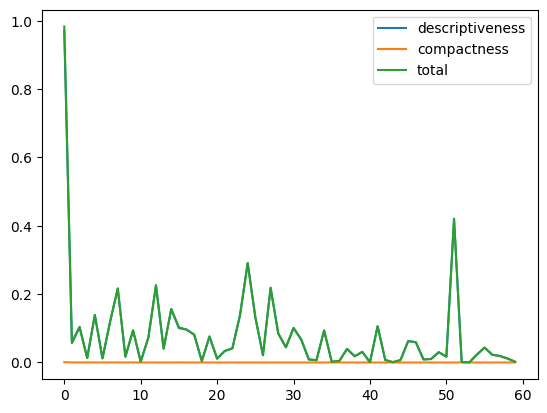

In [53]:
plt.plot(des_loss_list, label = 'descriptiveness')
plt.plot(com_loss_list, label = 'compactness')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()

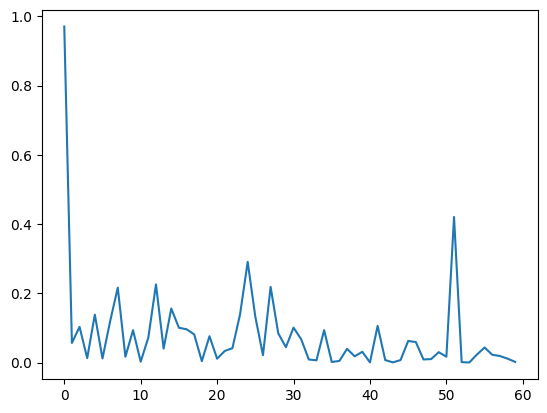

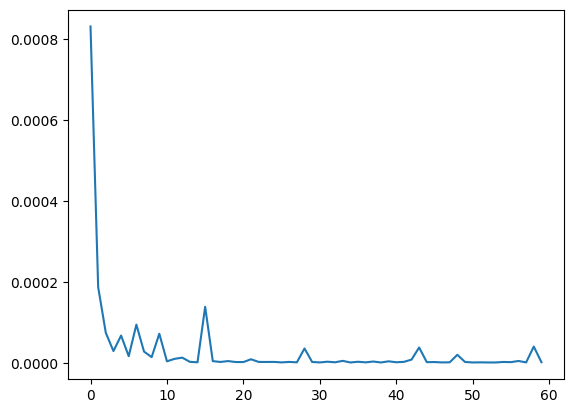

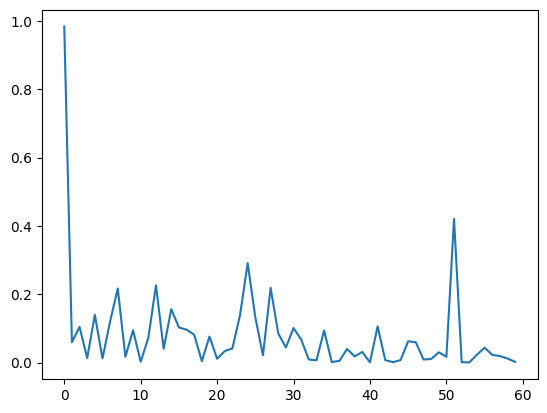

In [54]:
plt.plot(des_loss_list)
plt.show()
plt.plot(com_loss_list)
plt.show()
plt.plot(total_loss_list)
plt.show()

In [55]:
##Use feature extraction to add SVDD to input parameter setting

In [56]:
img_size = 224
flatten_size = 7* 7 * 512
n_samples = len(Tdata_train)
z_dim = 28
h_dim = [8, 4]
regular = 1e-5
max_lr = 1e-6
base_lr = 1e-4

n_epochs = 50
n_ae_epochs = 100
objective = 'soft-boundary'     #'one-class'  'soft-boundary'
nu = 0.1
warm_up_n_epochs = 10
optimizer = tf.keras.optimizers.Adam(lr = base_lr)
optimizer = tf.keras.optimizers.Adam(lr = base_lr)

In [57]:
##generate data as encoder input

In [58]:
def make_generate_model(model):
    
    model.trainable = False
    layer_name = 'block5_pool'
    x = model.get_layer(layer_name).output
    output = tf.reshape(x, shape = (-1, flatten_size))
    g_model = tf.keras.Model(inputs=model.input, outputs = output)
    
    return g_model
generate = make_generate_model(target_model)
generate.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [59]:
##MODEL CONSTRUCTION

In [60]:
def make_encoder():

    inputs = tf.keras.Input(shape=(flatten_size,), name='inputs')
    x = tf.reshape(inputs, shape = (-1, 28, 28, 32))
    x = tf.keras.layers.Conv2D(h_dim[0], (5, 5), activation='linear', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
    print(x.shape)
    x = tf.keras.layers.Conv2D(h_dim[1], (5, 5), activation='linear', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
    print(x.shape)
    _, h, _, _ = x.shape
    x = tf.reshape(x, shape = (-1, h * h * h_dim[1]))
    x = tf.keras.layers.Dense(z_dim)(x)
    print(x.shape)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
   
def make_decoder():

    inputs = tf.keras.Input(shape=(z_dim,), name='inputs')
    x = tf.keras.layers.Dense(h_dim[1] * 7 * 7)(inputs)
    x = tf.reshape(x, shape = (-1, 7, 7, h_dim[1]))
    x = tf.keras.layers.LeakyReLU()(x)
    #x = tf.keras.layers.UpSampling2D((2, 2))(x)    
    
    x = tf.keras.layers.Conv2DTranspose(h_dim[1], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)   
    print(x.shape)
        
    x = tf.keras.layers.Conv2DTranspose(h_dim[0], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x) 
    print(x.shape)
    
    x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    print(x.shape)
    
    x = tf.reshape(x, shape = (-1, flatten_size))
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    

encoder = make_encoder()
encoder.summary()

(None, 14, 14, 8)
(None, 7, 7, 4)
(None, 28)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25088)]           0         
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 28, 28, 32)        0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         6408      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )            

In [61]:
   def make_decoder():

    inputs = tf.keras.Input(shape=(z_dim,), name='inputs')
    x = tf.keras.layers.Dense(h_dim[1] * 7 * 7)(inputs)
    x = tf.reshape(x, shape = (-1, 7, 7, h_dim[1]))
    x = tf.keras.layers.LeakyReLU()(x)
    #x = tf.keras.layers.UpSampling2D((2, 2))(x)    
    
    x = tf.keras.layers.Conv2DTranspose(h_dim[1], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)   
    print(x.shape)
        
    x = tf.keras.layers.Conv2DTranspose(h_dim[0], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x) 
    print(x.shape)
    
    x = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='sigmoid', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    print(x.shape)
    
    x = tf.reshape(x, shape = (-1, flatten_size))
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
decoder = make_decoder()
decoder.summary()

(None, 14, 14, 4)
(None, 28, 28, 8)
(None, 28, 28, 32)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28)]              0         
                                                                 
 dense_5 (Dense)             (None, 196)               5684      
                                                                 
 tf.reshape_3 (TFOpLambda)   (None, 7, 7, 4)           0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 4)          404       
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 4)          16        
 hNo

In [62]:
def get_radius(dist, nu):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return tpf.stats.percentile(tf.sqrt(dist), 1 - nu)

def init_center_c(eps = 0.1):
    
    positive = tf.fill([z_dim], eps)
    negative = tf.fill([z_dim], -eps)
    c = tf.zeros(shape = [z_dim], dtype = tf.float32, name = 'c')
    n_sample = 0
    for batch, (batch_x) in enumerate(target_dataset):
        center= tf.reduce_sum(encoder(generate(batch_x, training = False), training = False), axis = 0, name = 'outputs')
        c = c +center
        n_sample = n_sample + batch_x.shape[0]
    c = c/n_sample
    # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.

    c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
    c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
    return c


@tf.function
def train_ae_model(batch_x):
    with tf.GradientTape() as ae_tape:
        generate_output = generate(batch_x, training =False)
        ae_output = decoder(encoder(generate_output, training=True), training=True)
        loss = tf.reduce_mean((ae_output - generate_output) ** 2)

    grads = ae_tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

    return loss

@tf.function
def train_model(batch_x, c, R, objective):
    with tf.GradientTape() as tape:
        generate_output = generate(batch_x, training =False)
        output = encoder(generate_output, training=True)
        dist = tf.reduce_sum((output - c) ** 2, 1)
      
        if objective == 'soft-boundary':
            scores = dist - R ** 2
            output_loss = R ** 2 + (1 / nu) * tf.reduce_mean(tf.maximum(tf.zeros_like(scores), scores))
        else:
            output_loss = tf.reduce_mean(dist)

    grads = tape.gradient(output_loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables))

    return output_loss, dist

In [63]:
##PRE-TRAIN

In [64]:
global_step = 0  
step_size = 2 * np.ceil(n_samples / batch_size)

for epoch in range(n_ae_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_ae_loss_avg = tf.metrics.Mean()
    
    for batch, (batch_x) in enumerate(target_dataset):
         # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

        optimizer.lr = clr
        ae_loss = train_ae_model(batch_x)
        
        epoch_ae_loss_avg(ae_loss)
        
    if epoch % 10 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  LOSS: {:.4f} '.format(epoch, epoch_time, epoch_ae_loss_avg.result()))

   0: TIME: 6.33  LOSS: 0.3734 
  10: TIME: 3.34  LOSS: 0.2311 
  20: TIME: 3.47  LOSS: 0.1852 
  30: TIME: 3.43  LOSS: 0.1670 
  40: TIME: 3.35  LOSS: 0.1587 
  50: TIME: 3.47  LOSS: 0.1550 
learning rate changed!
  60: TIME: 3.46  LOSS: 0.1527 
  70: TIME: 3.43  LOSS: 0.1518 
  80: TIME: 3.47  LOSS: 0.1505 
  90: TIME: 3.36  LOSS: 0.1501 


In [65]:
##TRAIN

   0: TIME: 4.61  LOSS: 2.7594 
  10: TIME: 3.79  LOSS: 0.4120 
  20: TIME: 3.21  LOSS: 0.1021 
  30: TIME: 3.29  LOSS: 0.0645 
  40: TIME: 3.32  LOSS: 0.0565 


/home/jovyan/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


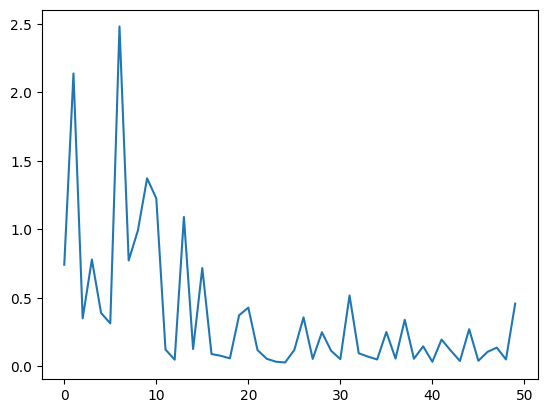

In [66]:
R = tf.zeros(shape = [1], dtype = tf.float32, name = 'R')
c = init_center_c(eps = 0.1)

pre_loss = 0
loss_list = []

for epoch in range(n_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_loss_avg = tf.metrics.Mean()    
   
    for batch, (batch_x) in enumerate(target_dataset):

        # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

        optimizer.lr = clr
        loss_, dist = train_model(batch_x, c, R, objective)
        
        epoch_loss_avg(loss_)

    if (objective == 'soft-boundary') and (epoch >= warm_up_n_epochs):
        R = get_radius(dist, nu)
        
    loss_list.append(loss_)
    if abs(pre_loss - loss_) < 1e-8:
        break
    pre_loss = loss_

    if epoch % 10 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  LOSS: {:.4f} '.format(epoch, epoch_time, epoch_loss_avg.result()))

plt.plot(loss_list)
plt.show()

In [67]:
def dist(target_dataset, center):
    i = 0
    for batch, (batch_x) in enumerate(target_dataset):
        
        generate_output = generate(batch_x, training =False)
        output = encoder(generate_output, training=True)
        distance = tf.reduce_sum(tf.square(output - center), 1) 
        if i==0:
            distances=distance
        else:
            distances = tf.concat([distances, distance], 0) 
        i = i + 1
    dis = distances.numpy() 
    plt.hist(dis, rwidth=0.3, color='b')
    plt.show()
    print(dis)

    return distances

In [68]:
def threshold(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 15  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size,3), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size,3), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

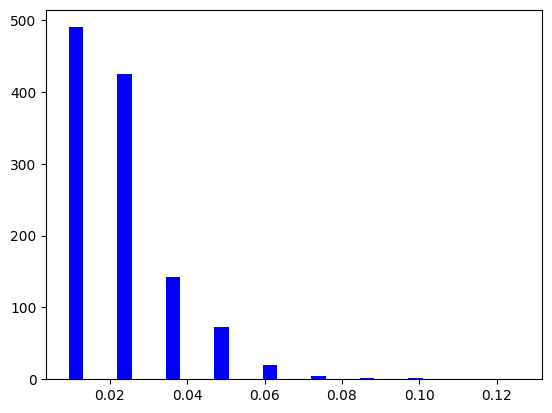

[0.01199162 0.00741773 0.01812268 ... 0.04378047 0.026439   0.02823514]


In [69]:
dists = dist(target_dataset, c)

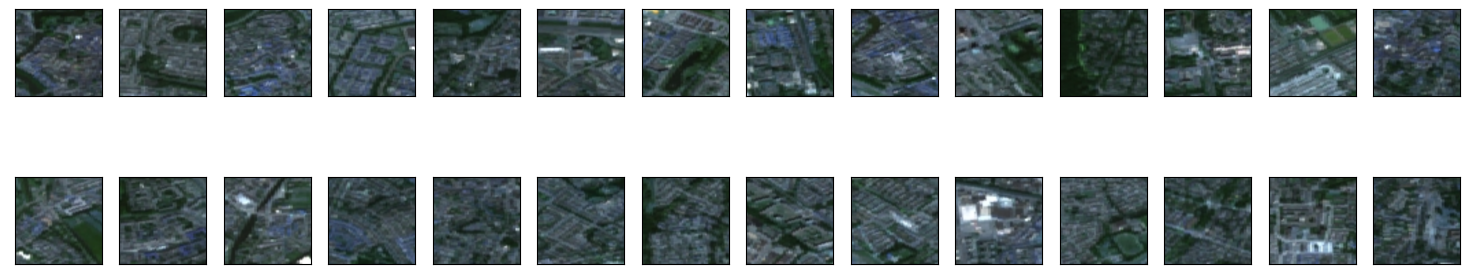

In [70]:
img_size = 224
threshold(Tdata_train, dists)

In [71]:
##TESTING

In [72]:
target_test_x = np.vstack((Rdata_test,Tdata_test))
target_test_y = [0] * len(Rdata_test) + [1] * len(Tdata_test)
target_test_x = np.array(target_test_x)
target_test_y = np.array(target_test_y)

In [73]:
idx = np.random.permutation(len(target_test_x))
target_test_x, target_test_y = target_test_x[idx], target_test_y[idx]

In [74]:
target_test_x.shape

(6198, 224, 224, 3)

In [75]:
target_test_y.shape

(6198,)

In [76]:
'''
y_true = []
y_scores = []
y_pred = [] 
result_test = np.zeros([2, len(target_test_x)]) 
for i in range(len(target_test_x)):
    
    genrate_output = generate(tf.expand_dims(target_test_x[i],0), training =False)
    dist = tf.reduce_sum(tf.square(encoder(genrate_output, training=False) - c), 1)
    
    if objective == 'soft-boundary':
        scores = dist - R ** 2
    else:
        scores = dist
        
    result_test[0, i] = target_test_y[i]
    result_test[1, i] = 1/scores
    y_true.append(result_test[0, i])
    y_scores.append(result_test[1, i])
    # Assign binary labels based on the scores and threshold
    if scores >= np.median(y_scores):
        y_pred.append(0.0)
    else:
        y_pred.append(1.0)'''

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
X = target_test_x.reshape(len(target_test_x), -1)
k = 2  # Set the desired number of neighbors for KNN
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X)
distances, _ = neigh.kneighbors(X)
result_test = np.zeros([2, len(target_test_x)]) 
for i in range(len(target_test_x)):
    genrate_output = generate(tf.expand_dims(target_test_x[i],0), training=False)
    dist = tf.reduce_sum(tf.square(encoder(genrate_output, training=False) - c), 1)
    
    if objective == 'soft-boundary':
        scores = dist - R ** 2
    else:
        scores = dist
        
    result_test[0, i] = target_test_y[i]
    result_test[1, i] = 1 / scores
    
    knn_distances = np.mean(distances[i])  # Compute the average distance to k nearest neighbors
    
    y_true.append(result_test[0, i])
    y_scores.append(result_test[1, i])
    
    # Assign binary labels based on the knn_distances and threshold
    if knn_distances >= np.median(y_scores):
        y_pred.append(0.0)
    else:
        y_pred.append(1.0)

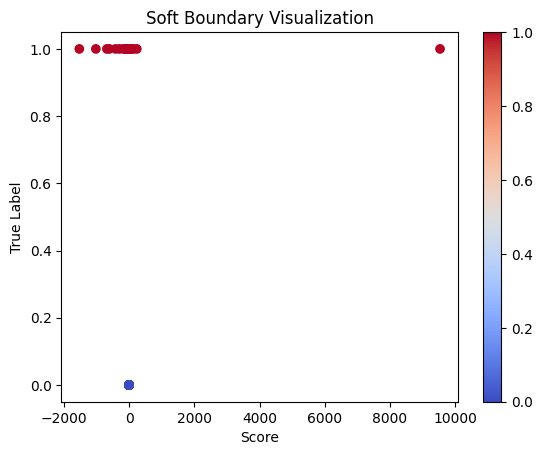

In [77]:
# Visualize soft boundary
plt.scatter(y_scores, y_true, c=y_pred, cmap='coolwarm')
plt.xlabel('Score')
plt.ylabel('True Label')
plt.title('Soft Boundary Visualization')
plt.colorbar()
plt.show()

In [78]:
print(np.median(y_scores))


0.12621376663446426


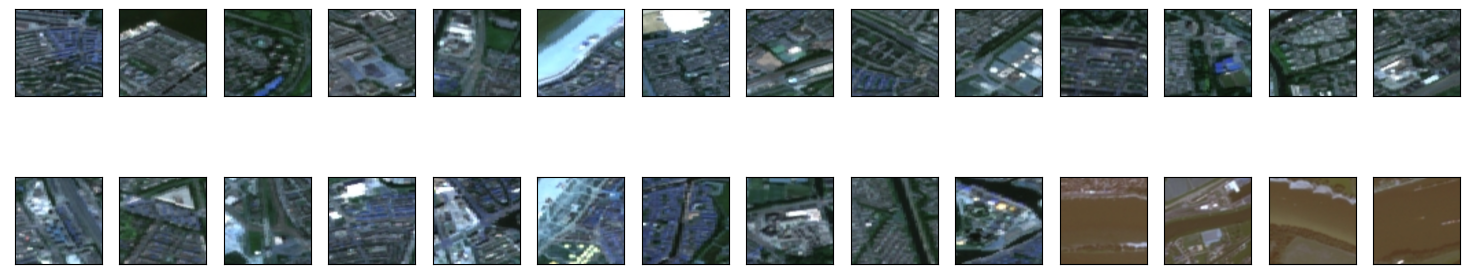

In [79]:
threshold(target_test_x, y_scores)

In [80]:
print(len(y_true))

6198


In [81]:
y_scores[:10]

[-18.748394012451172,
 0.07588165253400803,
 0.12120333313941956,
 0.7031821608543396,
 0.12194810062646866,
 0.09015937149524689,
 0.10306823253631592,
 0.17577318847179413,
 0.10946492105722427,
 0.16890838742256165]

In [82]:
y_true[:10]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [83]:
y_pred[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [84]:
from sklearn.metrics import roc_auc_score
# Convert the lists to numpy arrays if they are not already numpy arrays
y_scores = np.array(y_scores)

test_auc = roc_auc_score(y_true, y_scores)
print('AUC:', test_auc)

AUC: 0.020080321285140562


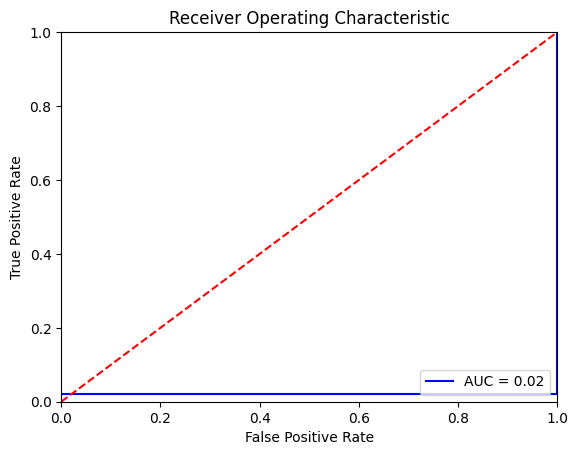

In [85]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_true, y_scores)
test_auc = auc(fpr, tpr)
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

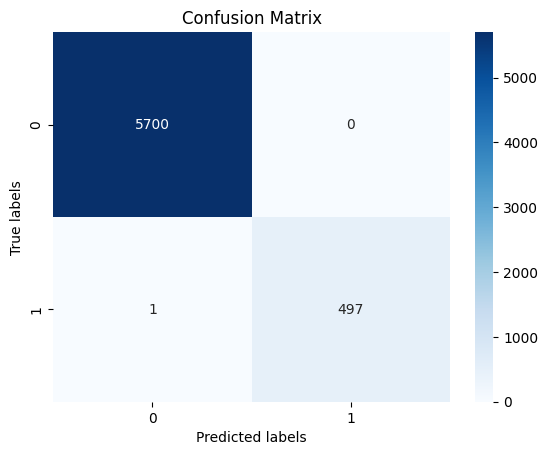

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 0.9979919678714859
F1 Score: 0.9989949748743718
Specificity: 1.0
Accuracy: 0.999838657631494


In [87]:
from sklearn.metrics import f1_score
# Convert the lists to numpy arrays if they are not already numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Compute the F1 score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8444948921679909


In [94]:
y_true_ar = y_true 
y_pred_ar = y_pred

In [95]:
# Extract the indices or boolean mask of false positives and false negatives
false_positive_indices = np.where((y_true_ar == 0) & (y_pred_ar == 1))[0]
false_negative_indices = np.where((y_true_ar == 1) & (y_pred_ar == 0))[0]
# Get the indices of true negatives
true_negative_indices = np.where((y_true_ar == 0) & (y_pred_ar == 0))[0]
# Extract the indices or boolean mask of the true positives
true_positive_indices = np.where((y_true_ar == 1) & (y_pred_ar == 1))[0]

In [98]:
x_train = target_test_x

In [99]:
# Visualize a specified number of true negative images
def visualize_images(image_list, num_images):
    fig = plt.figure(figsize=(10, 10))
    rows = columns = int(num_images ** 0.5)

    for i in range(num_images):
        if i >= len(image_list):
            break

        image_idx = image_list[i]
        image = x_train[image_idx]  # Access the image from x_train using the index

        ax = fig.add_subplot(rows, columns, i + 1)
        #ax.set_title("Image")
        ax.axis('off')
        ax.imshow(image)

    plt.tight_layout()
    plt.show()


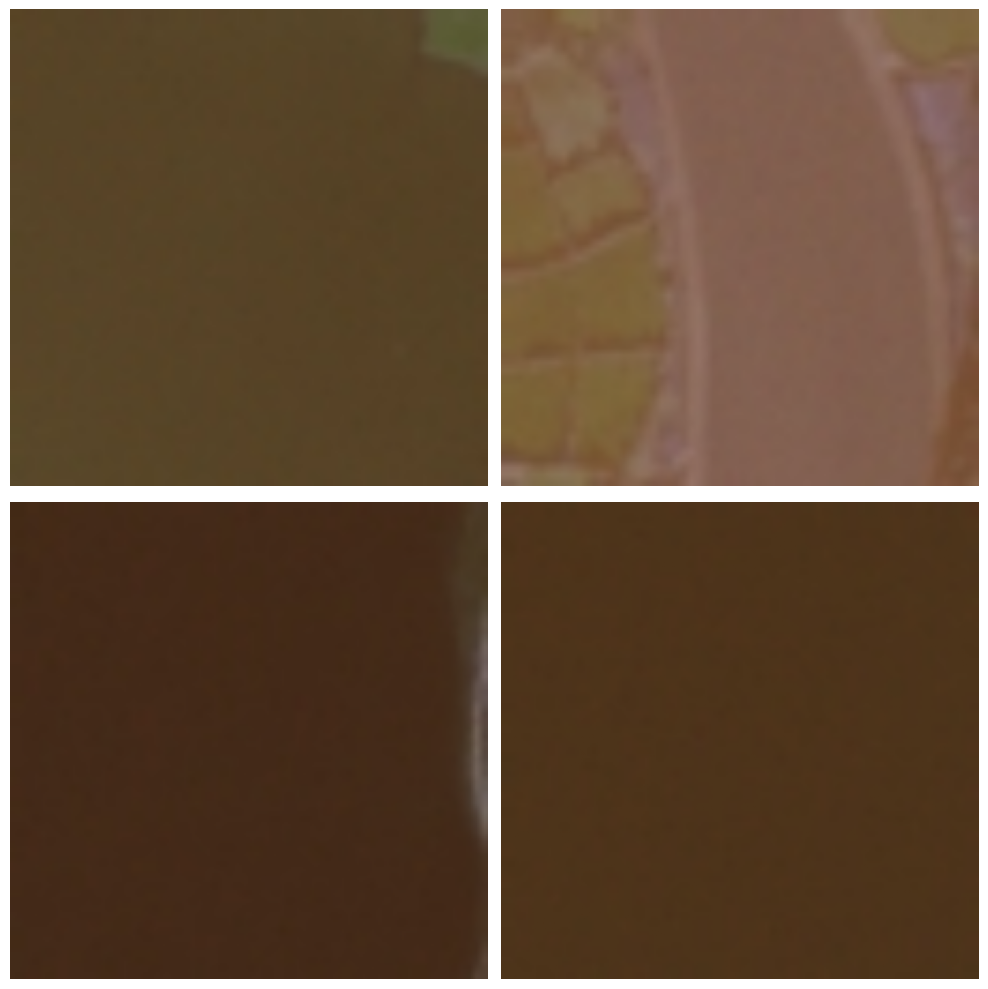

In [100]:
# Visualize 
visualize_images(true_negative_indices, num_images=4)

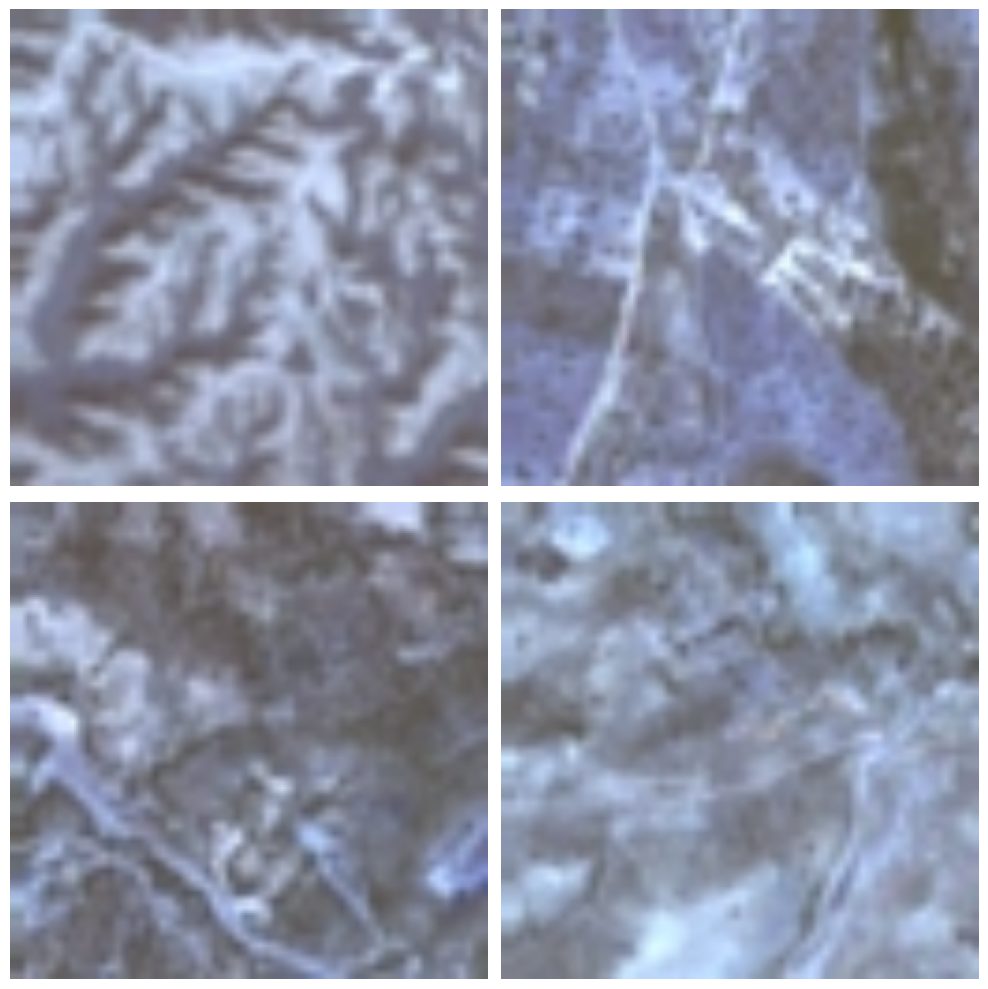

In [101]:
# Visualize 
visualize_images(false_positive_indices, num_images=4)

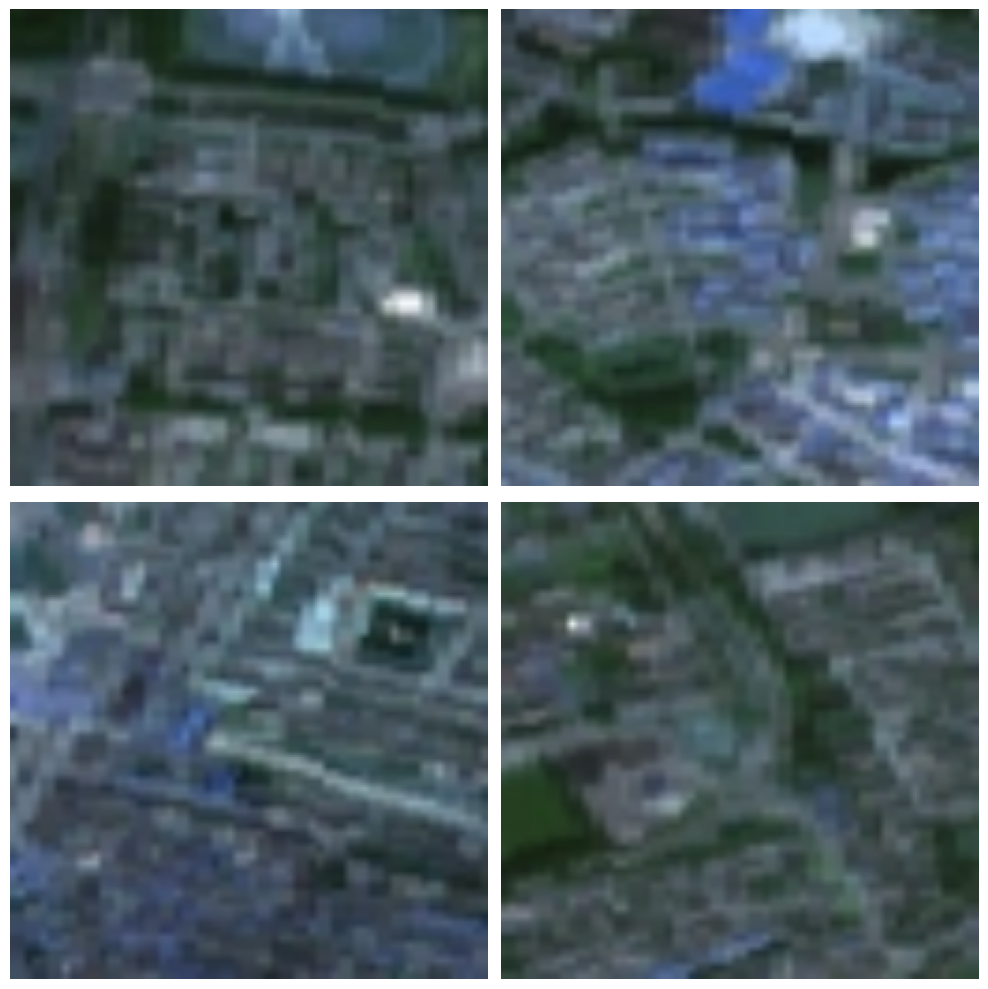

In [102]:
# Visualize 
visualize_images(false_negative_indices, num_images=4)

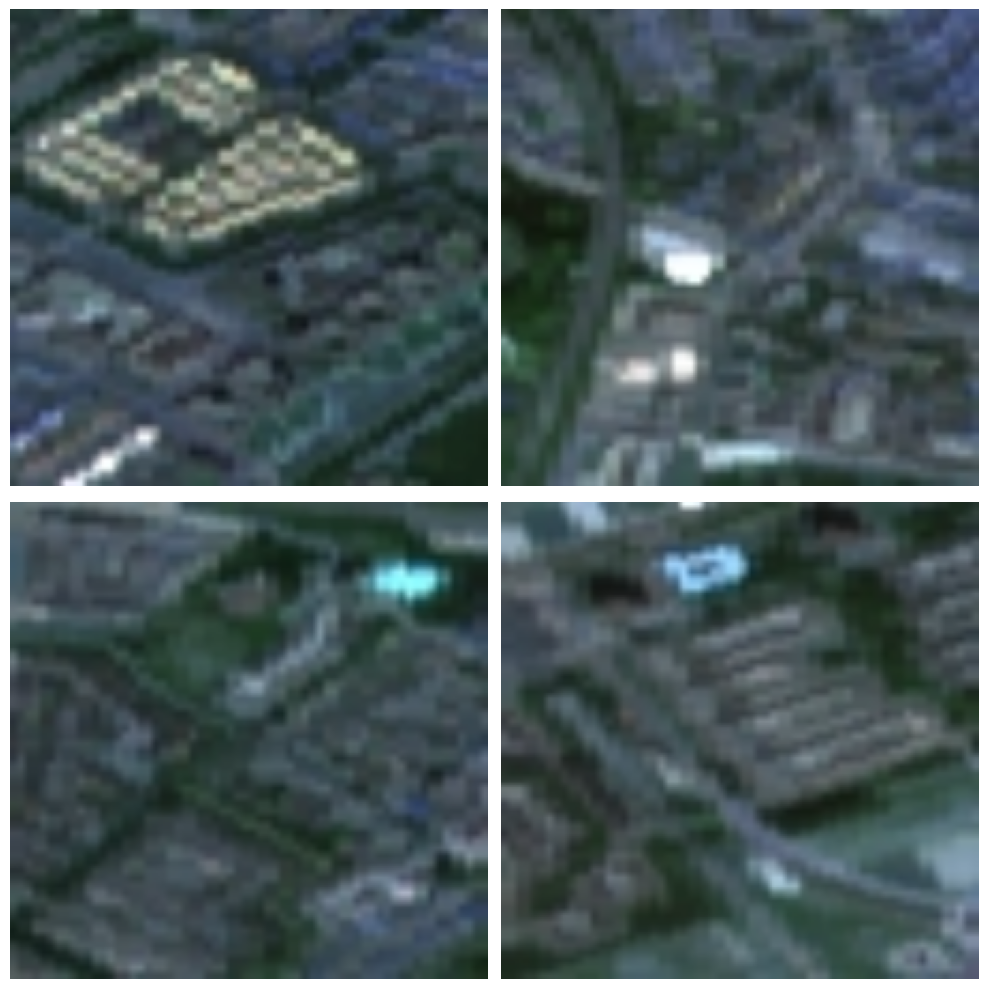

In [103]:
# Visualize 
visualize_images(true_positive_indices, num_images=4)

In [ ]:
plt.hist(y_scores[y_true==1.], rwidth = 0.3, color = 'r',label = 'normal')
plt.hist(y_scores[y_true==0.], rwidth = 0.3, color = 'b',label = 'imperviuos')
plt.legend()
plt.show()

In [ ]:
plt.hist(y_scores[y_true==1.], rwidth = 0.3, color = 'r',label = 'normal')

In [ ]:
plt.hist(y_scores[y_true==0.], rwidth = 0.3, color = 'b',label = 'anomaly')

In [90]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

In [91]:
# Create a TensorBoard callback
log_dir = "./logs"  # Directory to store TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Visualize the model using TensorBoard
tensorboard_callback.set_model(decoder)
tensorboard_callback.on_train_end(None)  # Write graph data to disk

# Generate a summary of the model and save it as an image
plot_model(decoder, to_file='decoder_model_summary.png', show_shapes=True)

print("CNN visualization saved as 'model_summary.png'")

CNN visualization saved as 'model_summary.png'
